# Stereo Vision: Window-based and Scan-line Stereo Matching

Complete implementation of stereo vision algorithms for 3D reconstruction from stereo pairs using the Tsukuba dataset.

## Overview

This notebook implements two main approaches to stereo vision:

1. **Window-based Stereo**: Traditional local aggregation methods
2. **Scan-line Stereo with Viterbi**: Advanced dynamic programming approaches with regularization

## Dataset

Uses the classic **Tsukuba dataset** - one of the oldest stereo datasets with dense ground-truth disparity maps, produced at University of Tsukuba in 2001.

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as image
from matplotlib.colors import LogNorm
from skimage import img_as_ubyte
from skimage.color import rgb2gray

from numpy import linalg as LA

In [3]:
def integral_image(img):
    return np.cumsum(np.cumsum(img, axis=0), axis=1)

In [4]:
def SD_array(imageL, imageR, d_minimum, d_maximum):
    imageL_float = imageL.astype(np.float64)
    imageR_float = imageR.astype(np.float64)
    SD = np.zeros((1+d_maximum-d_minimum, np.shape(imageL)[0], np.shape(imageL)[1]))
    for i in range(d_minimum, 1+d_maximum):
        im_right_roll = np.roll(imageR_float, i, axis=1)
        SD_slice = LA.norm(imageL_float - im_right_roll, axis=2) ** 2
        SD[i - d_minimum,:,:] = SD_slice
    return SD

In [5]:
def viterbi_7b(im_left, im_right, d_min, d_max, w, window_size):
    drange = d_max - d_min + 1
    height, width = im_left.shape[:2]
    E_bar = np.full((drange, height, width), np.inf)
    SD_array_image = SD_array(im_left, im_right, d_min, d_max)
    
    for d in range(drange):
        smoothed_SD = windSum(SD_array_image[d], window_size)
        finite_mask = np.isfinite(smoothed_SD)
        if np.any(finite_mask):
            mean_val = np.mean(smoothed_SD[finite_mask])
            std_val = np.std(smoothed_SD[finite_mask])
            penalty = mean_val + 3 * std_val
            smoothed_SD[~finite_mask] = penalty
        else:
            smoothed_SD = np.full_like(smoothed_SD, 1000.0)
        SD_array_image[d] = smoothed_SD
    
    for d in range(drange):
        E_bar[d, :, 0] = SD_array_image[d, :, 0]
    
    for col in range(1, width):
        for d_curr in range(drange):
            for row in range(height):
                data_cost = SD_array_image[d_curr, row, col]
                min_transition_cost = np.inf
                for d_prev in range(drange):
                    transition_cost = w * abs(d_curr - d_prev)
                    total_cost = E_bar[d_prev, row, col-1] + transition_cost
                    min_transition_cost = min(min_transition_cost, total_cost)
                E_bar[d_curr, row, col] = data_cost + min_transition_cost
    
    disparity_map = np.zeros((height, width), dtype=int)
    for row in range(height):
        disparity_map[row, -1] = np.argmin(E_bar[:, row, -1])
    
    for col in range(width-2, -1, -1):
        for row in range(height):
            d_curr = disparity_map[row, col+1]
            min_cost = np.inf
            best_d_prev = 0
            for d_prev in range(drange):
                transition_cost = w * abs(d_curr - d_prev)
                total_cost = E_bar[d_prev, row, col] + transition_cost
                if total_cost < min_cost:
                    min_cost = total_cost
                    best_d_prev = d_prev
            disparity_map[row, col] = best_d_prev
    
    return disparity_map

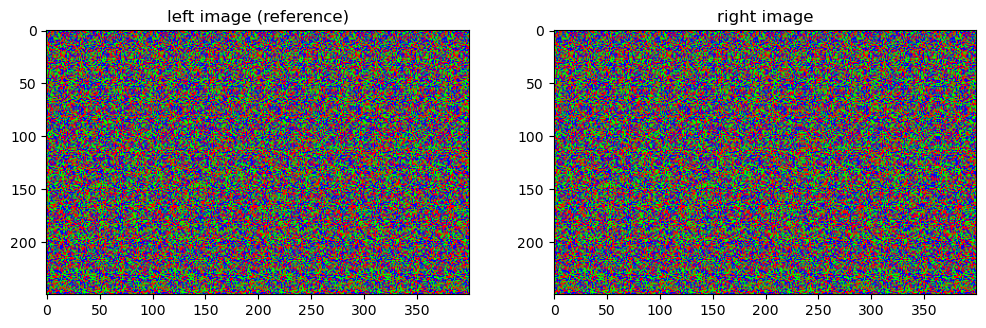

In [6]:
# you should use this random dot stereo pair for code developing/testing in Probelms 1-5
im_left = image.imread("images/stereo_pairs/rds_left.gif")
im_right = image.imread("images/stereo_pairs/rds_right.gif")

fig = plt.figure(figsize = (12, 5))
plt.subplot(121)
plt.title("left image (reference)")
plt.imshow(im_left)
plt.subplot(122)
plt.title("right image")
plt.imshow(im_right)

# the range of disparities for this random dot stereo pair 
d_min = 0
d_max = 2

## Part 1: Squared Difference Computation

Compute the squared L2 norm between RGB pixels of the left and right images.

**Key Implementation Details:**
- Convert RGB values to `float64` to prevent overflow bugs
- Use L2 norm: $D = ||I_L - I_R||^2$
- Essential first step for all stereo algorithms

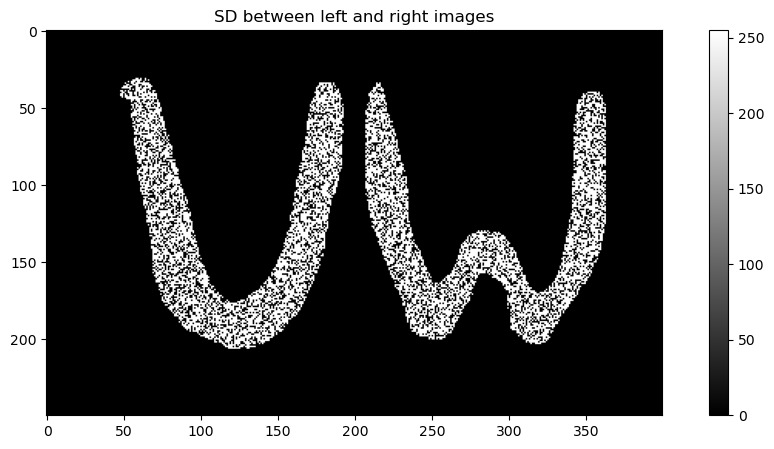

In [7]:
SD = np.zeros(np.shape(im_left)) 
SD = LA.norm(im_left - im_right, axis=2) 

fig = plt.figure(figsize = (12, 5))
plt.title("SD between left and right images")
plt.imshow(SD, cmap = "gray")
plt.colorbar()

## Part 2: Squared Difference Array Function

Compute squared differences for **all disparity values** $d \in [d_{min}, d_{max}]$ by shifting the right image horizontally.

**Algorithm:**
- Shift right image by $d$ pixels for each disparity value
- Compute L2 squared difference: $SD[d] = ||I_L - shift(I_R, d)||^2$
- Return 3D array where $SD[i, r, c]$ contains squared difference for disparity $i$ at pixel $(r,c)$

**Disparity Range:** Typically $d \in [0, 15]$ for Tsukuba dataset

In [8]:
h = range(1, 90)




### Visualizing Squared Differences

Display squared difference images for minimum, middle, and maximum disparity values to understand how the matching behaves across the disparity range.

**Insight:** 
- Low disparity values (background) show different features than high disparity values (foreground objects)
- This visualization helps understand the matching behavior

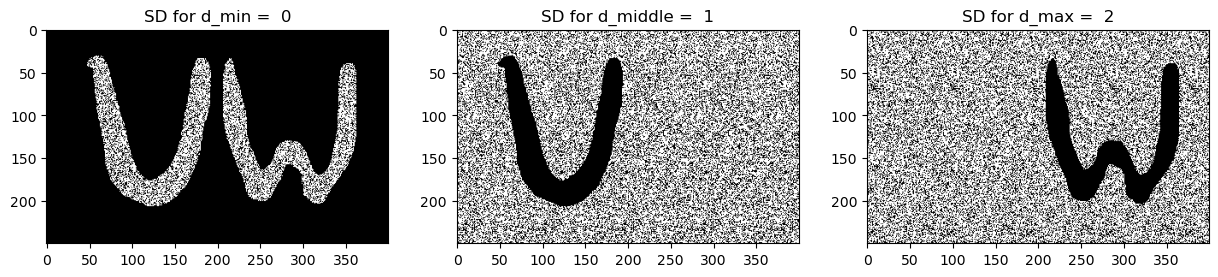

In [9]:
SD = SD_array(im_left, im_right, d_min, d_max)    

fig = plt.figure(figsize = (15, 4))
plt.subplot(131)
plt.title('SD for d_min = {:>2d}'.format(d_min))
plt.imshow(SD[0], cmap = "gray")
plt.subplot(132) 
d_middle = round((d_min+d_max)/2)
plt.title('SD for d_middle = {:>2d}'.format(d_middle))
plt.imshow(SD[d_middle-d_min], cmap = "gray")
plt.subplot(133)
plt.title('SD for d_max = {:>2d}'.format(d_max))
plt.imshow(SD[d_max-d_min], cmap = "gray")
#plt.colorbar(cax=plt.axes([0.91, 0.25, 0.01, 0.5]))

## Part 3: Integral Image Function

Compute the **integral image** (summed area table) for efficient window operations.

**Why Integral Images?**
- Enable $O(1)$ window sum queries
- Critical for fast SSD computation  
- Foundation for all window-based stereo methods

**Formula:** 

$$I(x,y) = \sum_{i=0}^{x} \sum_{j=0}^{y} img(i,j)$$

### Computing Integral Images for All Disparities

Apply the integral image function to each disparity level to prepare for efficient window sum computation.

This creates the foundation for **Sum of Squared Differences (SSD)** - the core metric for window-based stereo matching.

$$SSD_d = I(x,y) = \sum_{i=0}^{x} \sum_{j=0}^{y} SD[d](i,j)$$

(3, 250, 400) (3, 250, 400)


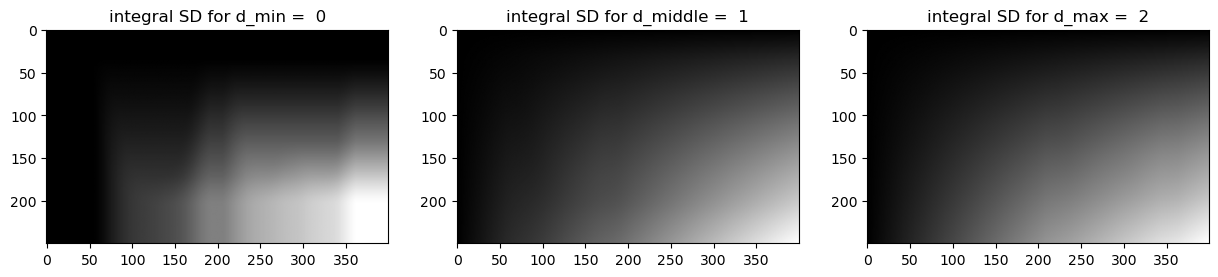

In [10]:
integral_SD = np.zeros(np.shape(SD))
print(np.shape(integral_SD),np.shape(SD))

for Delta in range(1+d_max-d_min):
    integral_SD[Delta] = integral_image(SD[Delta])
        
fig = plt.figure(figsize = (15, 4))
plt.subplot(131)
plt.title('integral SD for d_min = {:>2d}'.format(d_min))
plt.imshow(integral_SD[0], cmap = "gray")
plt.subplot(132) 
d_middle = round((d_min+d_max)/2)
plt.title('integral SD for d_middle = {:>2d}'.format(d_middle))
plt.imshow(integral_SD[d_middle-d_min], cmap = "gray")
plt.subplot(133)
plt.title('integral SD for d_max = {:>2d}'.format(d_max))
plt.imshow(integral_SD[d_max-d_min], cmap = "gray")
#plt.colorbar(cax=plt.axes([0.91, 0.2, 0.01, 0.6]))

## Part 4: Window Sum Function

Compute **Sum of Squared Differences (SSD)** by aggregating values within fixed-size windows using integral images.

**Key Features:**
- Works with any window size $h \in \{1,2,3,4,5,\ldots\}$
- Uses integral images for $O(1)$ window sum computation
- Margins filled with $\infty$ to mark invalid regions

**Window Size Effects:**
- Small windows ($h=1-3$): More detail, more noise
- Large windows ($h=15-20$): Smoother results, less detail

**Window Sum Formula:**

$$SSD_d(x,y) = I(x+h/2, y+h/2) - I(x-h/2, y+h/2) - I(x+h/2, y-h/2) + I(x-h/2, y-h/2)$$

In [11]:
def shift_integral_image(x2,a,b):
    x3 = np.roll(x2, (a,b), axis=(0,1))
    return x3
def shift_integral_image_2(x2,a,b):
    x3 = np.roll(x2, (-a,-b), axis=(0,1))
    return x3

In [12]:
# function windSum can be applied to any scalar 2D array/image. It should return an array/image where the value of 
# each element (pixel p) is the "sum" of the values in the input array/image within a window around element p.
# The return image should be of the same size/type and have its margins (around half-window width) filled with INFTY.
# NOTE: you should use function integral_image implemented earlier.
# HINT: you should use standard np.roll function to avoid double or triple for loops.
INFTY = np.inf

def windSum(img, window_width):
    img_integral = integral_image(img)
    # Roll the x and y values by - math.floor((window_width - 1) / 2). Which 
    f = img_integral - shift_integral_image(img_integral,0,window_width) - shift_integral_image(img_integral,window_width,0) + shift_integral_image(img_integral,window_width,window_width)
    shift_1 = int(np.floor( (window_width - 1) / 2))
    shift_2 = int(np.ceil(window_width / 2))
    sample = (np.ones(img.shape) * np.inf)
    core_center_need_padding_image = f[window_width - 1:,window_width - 1:]
    sample[shift_1 :shift_1 + core_center_need_padding_image.shape[0],shift_1 :shift_1 + core_center_need_padding_image.shape[1]] = core_center_need_padding_image
    return sample

In [13]:
def right_down(x2,a,b):
    x3 = np.roll(x2, (a,b), axis=(0,1))
    return x3
def left_up(x2,a,b):
    x3 = np.roll(x2, (-a,-b), axis=(0,1))
    return x3

### Computing SSD for Multiple Window Sizes

Compare SSD images for different window sizes to understand the trade-off between detail and smoothness.

**Expected Results:**
- Window size = 1: Maximum detail, raw squared differences
- Window size > 1: Smoother but less detailed results

This demonstrates the fundamental trade-off in stereo vision: **detail vs. smoothness**

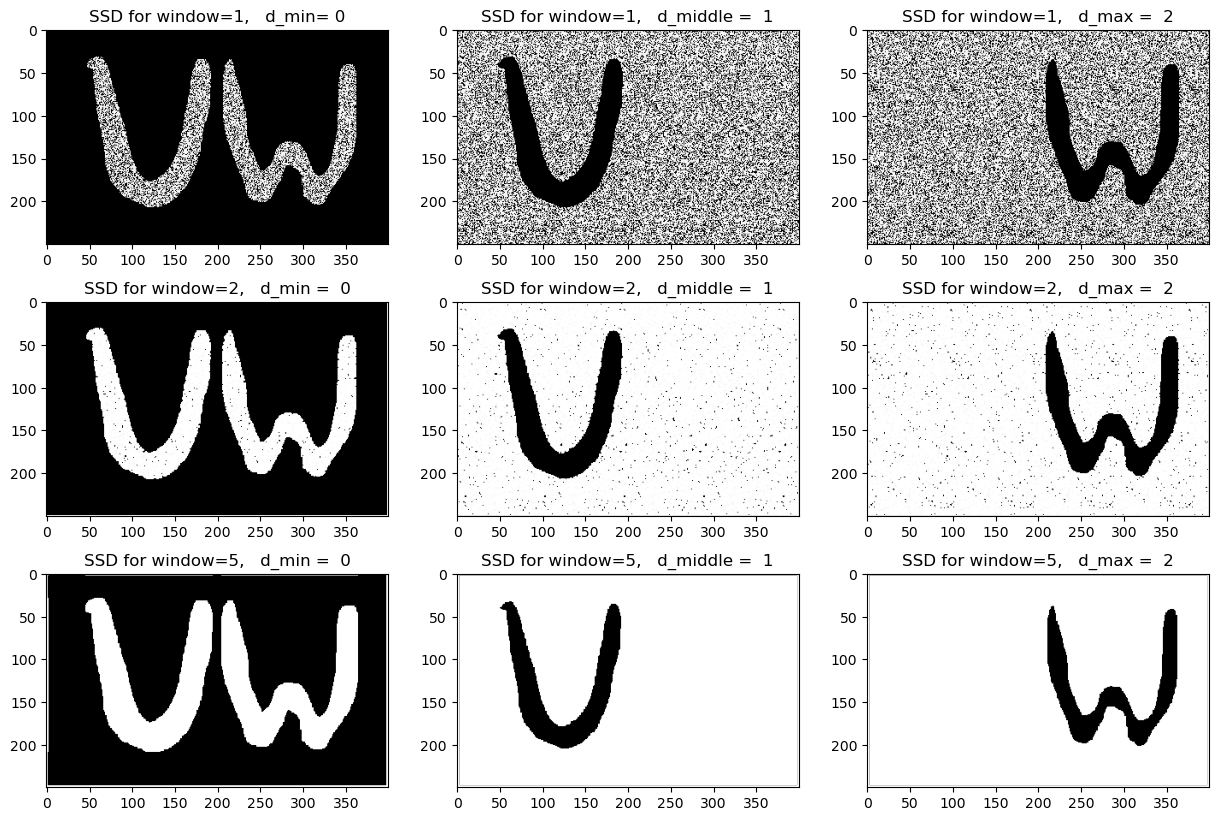

In [14]:
SSD1 = np.zeros(np.shape(SD))
SSD2 = np.zeros(np.shape(SD))
SSD5 = np.zeros(np.shape(SD))

for Delta in range(1+d_max-d_min):
    SSD1[Delta] = windSum(SD[Delta],1)
    SSD2[Delta] = windSum(SD[Delta],2)
    SSD5[Delta] = windSum(SD[Delta],5)


d_middle = round((d_min+d_max)/2)
        
fig = plt.figure(figsize = (15, 10))
plt.subplot(331)
plt.title('SSD for window=1,   d_min={:>2d}'.format(d_min))
plt.imshow(1+SSD1[0], cmap = "gray", norm=LogNorm(vmin=1, vmax=200000))
plt.subplot(332) 
plt.title('SSD for window=1,   d_middle = {:>2d}'.format(d_middle))
plt.imshow(1+SSD1[d_middle-d_min], cmap = "gray", norm=LogNorm(vmin=1, vmax=200000))
plt.subplot(333)
plt.title('SSD for window=1,   d_max = {:>2d}'.format(d_max))
plt.imshow(1+SSD1[d_max-d_min], cmap = "gray", norm=LogNorm(vmin=1, vmax=200000))
plt.subplot(334)
plt.title('SSD for window=2,   d_min = {:>2d}'.format(d_min))
plt.imshow(1+SSD2[0], cmap = "gray", norm=LogNorm(vmin=1, vmax=200000))
plt.subplot(335) 
plt.title('SSD for window=2,   d_middle = {:>2d}'.format(d_middle))
plt.imshow(1+SSD2[d_middle-d_min], cmap = "gray", norm=LogNorm(vmin=1, vmax=200000))
plt.subplot(336)
plt.title('SSD for window=2,   d_max = {:>2d}'.format(d_max))
plt.imshow(1+SSD2[d_max-d_min], cmap = "gray", norm=LogNorm(vmin=1, vmax=200000))
plt.subplot(337)
plt.title('SSD for window=5,   d_min = {:>2d}'.format(d_min))
plt.imshow(1+SSD5[0], cmap = "gray", norm=LogNorm(vmin=1, vmax=200000))
plt.subplot(338) 
plt.title('SSD for window=5,   d_middle = {:>2d}'.format(d_middle))
plt.imshow(1+SSD5[d_middle-d_min], cmap = "gray", norm=LogNorm(vmin=1, vmax=200000))
plt.subplot(339)
plt.title('SSD for window=5,   d_max = {:>2d}'.format(d_max))
plt.imshow(1+SSD5[d_max-d_min], cmap = "gray", norm=LogNorm(vmin=1, vmax=200000))

## Part 5: Disparity Map from SSD

Compute the final **disparity map** by selecting the disparity with minimum SSD at each pixel.

**Algorithm:**
$$\text{disparity}(x,y) = \arg\min_d SSD_d(x,y)$$

**Key Points:**
- At each pixel $(x,y)$, find $d$ that minimizes $SSD_d(x,y)$
- For margin pixels (with $SSD = \infty$), set disparity to $0$
- This is the **Winner-Takes-All** approach

In [15]:
# You should use functions np.where (pointwise "if, then, else" operation) and np.minimum (pointwise "minimum" operation)
# These functions will help to avoid double loops for traversing the pixels.
# WARNING: there will be a deducton for double-loops traversing pixels, but single loop to traverse disparities is OK.
# for all parts that have zero error apply the i and all parts that is non-zero apply 
def SSDtoDmap(SSD_array, d_minimum, d_maximum):
    # print(SSD_array.shape)
    dMap = np.full(np.shape(SSD_array[0]),d_minimum)
    dMap [SSD_array[0] == INFTY] = 0
    SSD_minimum = SSD_array[0]
    dMap [:,:] = 0
    for i in range(1+d_maximum-d_minimum):
        dMap [SSD_array[i] < SSD_minimum] = i
        SSD_minimum = np.minimum(SSD_minimum, SSD_array[i])
    return dMap

### Disparity Map Visualization

Display disparity maps computed with different window sizes to compare the effects of aggregation.

**Observations:**
- Larger windows produce smoother disparity maps
- Smaller windows preserve more details but have more noise
- Window size is a critical parameter for balancing quality and detail

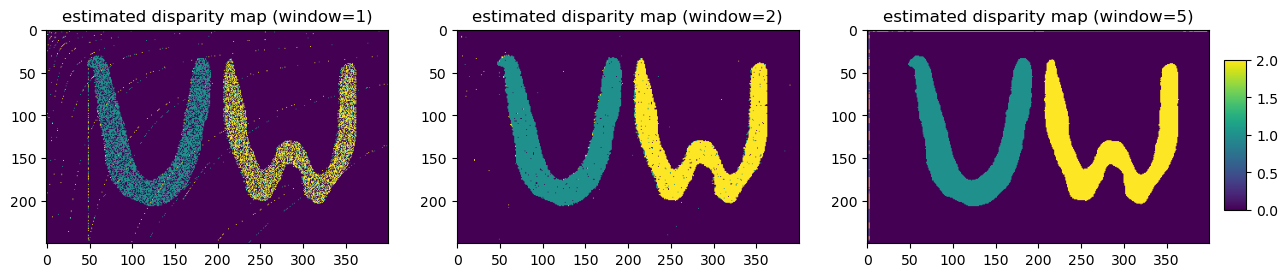

In [16]:
dMap1 = SSDtoDmap(SSD1,d_min,d_max)
dMap2 = SSDtoDmap(SSD2,d_min,d_max)
dMap5 = SSDtoDmap(SSD5,d_min,d_max)

fig = plt.figure(figsize = (15, 3))
plt.subplot(131)
plt.title("estimated disparity map (window=1)")
plt.imshow(dMap1, vmin = 0, vmax = d_max)
plt.subplot(132)
plt.title("estimated disparity map (window=2)")
plt.imshow(dMap2, vmin = 0, vmax = d_max)
plt.subplot(133)
plt.title("estimated disparity map (window=5)")
plt.imshow(dMap5, vmin = 0, vmax = d_max)
plt.colorbar(cax=plt.axes([0.91, 0.25, 0.015, 0.5]))

### Problem 6: test your code on a real stereo pair with ground truth (Tsukuba)

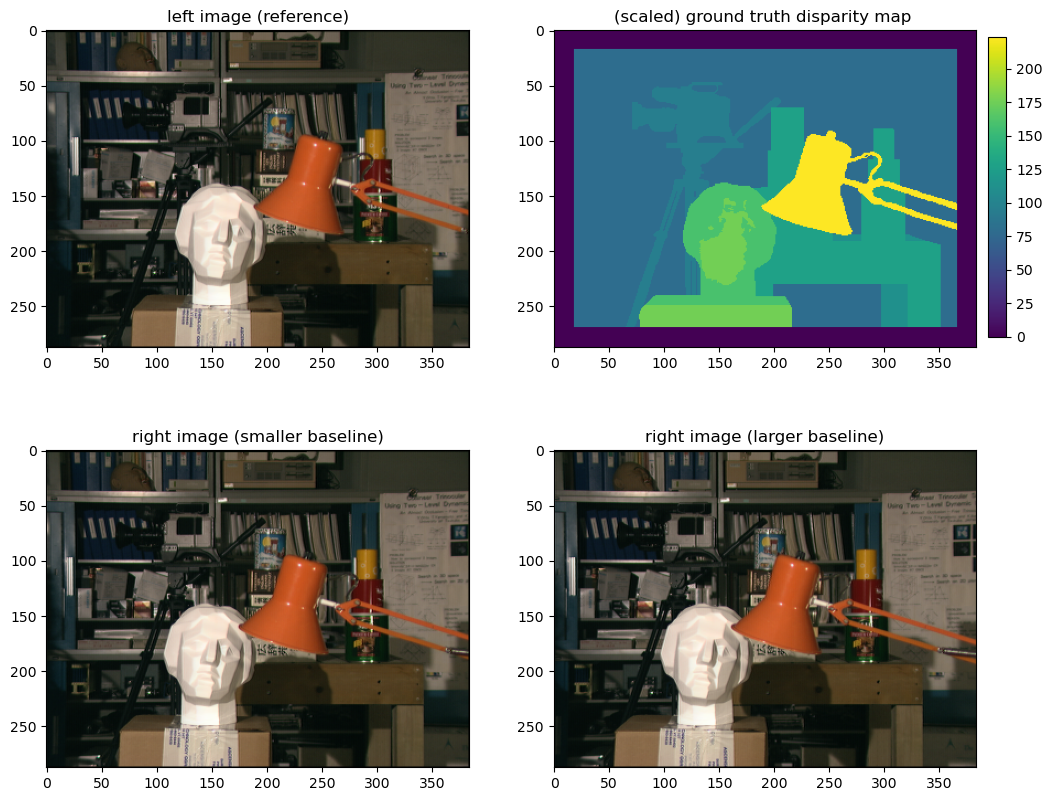

In [17]:
# images/tsukuba subdirectory contains (a subset of) "Tsukuba" stereo images that are probably 
# the oldest stereo data with dense ground-truth produced at the University of Tsukuba in 2001. 
# The full Tsukuba dataset and many other stereo images with ground-truth disparity maps can be
# downloaded from well-known Middlebury repository  http://vision.middlebury.edu/stereo/
im_left = image.imread("images/stereo_pairs/tsukuba/scene1.row3.col3.ppm")
im_gt = image.imread("images/stereo_pairs/tsukuba/truedisp.row3.col3.pgm")
im_right = image.imread("images/stereo_pairs/tsukuba/scene1.row3.col4.ppm")
im_right2 = image.imread("images/stereo_pairs/tsukuba/scene1.row3.col5.ppm")

fig = plt.figure(figsize = (12, 10))
plt.subplot(221)
plt.title("left image (reference)")
plt.imshow(im_left)
plt.subplot(222) 
plt.title("(scaled) ground truth disparity map ")
plt.imshow(im_gt)
plt.colorbar(cax=plt.axes([0.91, 0.557, 0.015, 0.3]))
plt.subplot(223)
plt.title("right image (smaller baseline)")
plt.imshow(im_right)
plt.subplot(224)
plt.title("right image (larger baseline)")
plt.imshow(im_right2)

### Note that the integer-valued ground truth image above represents scaled disparity values for the pixels in the reference (left) mage. The scale w.r.t. the smaller baseline right image ($\text{im_right}$) is 16 and for the larger baseline image ($\text{im_right2}$) is 8. Below, you should use the smaller-baseline right image ($\text{im_right}$). 

### Problem 6a: Using ground truth disparity map, estimate the range of disparity values between pixels in the left image ($\text{im_left}$) and the right image ($\text{im_right}$) .

In [18]:
# Solution: use standard functions to find min and max values in the ground truth disparity map. 
# You should ignore 0-valued margin!

d_min = 0 # change me
d_max = 12 # change me




### Compute squared differences using $\text{SD_array}$ function and visualize the results using logarithmic scale. Note that linear scale would make it hard to see smaller squared differences since there are many very large ones. (fully implemented)

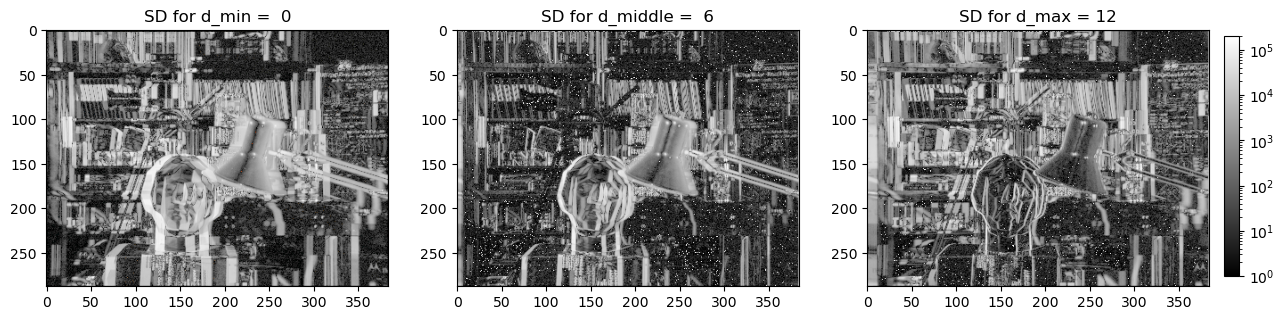

In [19]:
SD = SD_array(im_left, im_right, d_min, d_max)    
    
fig = plt.figure(figsize = (15, 4))
plt.subplot(131)
plt.title('SD for d_min = {:>2d}'.format(d_min))
plt.imshow(im_left)
plt.imshow(SD[0], cmap = "gray", norm=LogNorm(vmin=1, vmax=200000))
plt.subplot(132) 
d_middle = round((d_min+d_max)/2)
plt.title('SD for d_middle = {:>2d}'.format(d_middle))
plt.imshow(SD[d_middle-d_min], cmap = "gray", norm=LogNorm(vmin=1, vmax=200000))
plt.subplot(133)
plt.title('SD for d_max = {:>2d}'.format(d_max))
plt.imshow(SD[d_max-d_min], cmap = "gray", norm=LogNorm(vmin=1, vmax=200000))
plt.colorbar(cax=plt.axes([0.91, 0.2, 0.01, 0.6]))

### Problem 6b: Explain the differences you observe above:

answer:

for $$dmin = 0$$ I mainly see the features of the background and for higher levles of disparity I have seen more of the features of the face and the lamp

### Problem 6c: Write function $\text{Dmap_Windows}$ that returns disparith map from a given stereo pair (left and right image), specified disparity range, and window size. Your implementation should combine functions implemented and debugged earlier ($\text{SD_array}$, $\text{windSum}$, and $\text{SSDtoDmap}$).

In [20]:
def Dmap_Windows(imageL, imageR, d_minimum, d_maximum, window_width):
    SD = SD_array(imageL, imageR, d_minimum, d_maximum)   
    SSD = np.zeros(np.shape(SD))

    for Delta in range(1+d_maximum-d_minimum):
        SSD[Delta] = windSum(SD[Delta],window_width)
    dMap = SSDtoDmap(SSD, d_minimum, d_maximum)
    return dMap









im_left = image.imread("images/stereo_pairs/rds_left.gif")
im_right = image.imread("images/stereo_pairs/rds_right.gif")
d_min = 0
d_max = 2

### Compute and show disparity maps for Tsukuba using small and large windows. (fully implemented)

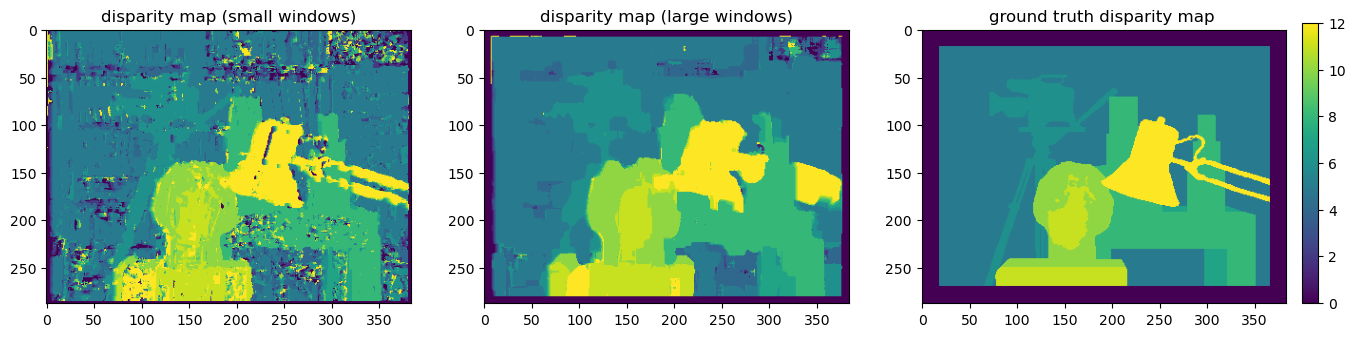

In [21]:
dispMap_small = Dmap_Windows(im_left, im_right, d_min, d_max, 4)
dispMap_large = Dmap_Windows(im_left, im_right, d_min, d_max, 15)

fig = plt.figure(figsize = (16, 7))
plt.subplot(131)
plt.title("disparity map (small windows)")
plt.imshow(dispMap_small, vmin = 0, vmax = d_max)
plt.subplot(132)
plt.title("disparity map (large windows)")
plt.imshow(dispMap_large, vmin = 0, vmax = d_max)
plt.subplot(133) 
plt.title("ground truth disparity map ")
plt.imshow(im_gt/16, vmin = 0, vmax = d_max)
plt.colorbar(cax=plt.axes([0.91, 0.3, 0.01, 0.4]))








# Part II: Scan-line stereo   $\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\longleftarrow 30\;pts$

### Problem 7(a):  Program $Viterbi$ approach discussed in class and apply it to Tsukuba example. For the photo-consistency term  of the loss function (objective function) you can use previously implemented $\text{SD_array}$ $$D_p(d) = |I_p-I_{p+d}|^2 \;\;\;\;\;\longleftarrow\;\;\;\; \text{SD_array}[d][p] $$ that for every pixel $p$ defines the cost for every possible disparity value $d\in\{d_{min},...,d_{max}\}$. The regularization term should be $$V_{pq}(d_p,d_q) = w|d_p-d_q|$$ where you can select some value for parameter $w$ empirically (start from $w\approx 0$).  Discuss the differences with the results of the window-based stereo above.

### NOTE: You should implement $Viterbi$ optimization yourself - it was fully covered in class. Organize your code (e.g. add cells, introduce functions, write comments, ect) as part of your mark will depend on clarity. The main iteration of the forward pass in Viterbi ($m^2$-complexity operation for each pair of neighboring pixels on a scan-line) can be implemented as a separate function. You can avoid double for-loops using functions like  𝑛𝑝.𝑤ℎ𝑒𝑟𝑒 ,  𝑛𝑝.𝑚𝑖𝑛𝑖𝑚𝑢𝑚 ,  𝑛𝑝.𝑠𝑞𝑢𝑎𝑟𝑒 ,  𝑛𝑝.𝑜𝑔𝑟𝑖𝑑  or others similar general "vectorized" functions in numpy that alow to avoid multi-loops over matrix (image) elements (pixels).

For every line/row on the right image I am going to assume $$V_{pq}(d_p,d_q) = w|d_p-d_q| = w|dispMap[p] - dispMap[p+1]|$$

For lower values of $w$ the disparity within a scanline seems to be noisy. Which is understandable as differnces between neighboring pixels are not peanlized. Where as for values other than $0$ the line is smoother. This comes at a cost in the form of loss of details when $w$ is set to high

In [22]:
'''
i is the the disparity value of the previouse column and k is the current value
this function returns a matrix where E[i,k] signifies the value at E_bar[k,p] if taken at i
'''
def D(SD_array_image, row, drange, p):
    empty_grid = np.ogrid[0:drange,0:drange]
    i = empty_grid[0]
    k = empty_grid[1]
    return SD_array_image[k, row, p]
def V(drange):
    empty_grid = np.ogrid[0:drange,0:drange]
    i = empty_grid[0]
    k = empty_grid[1]
    return np.abs(k - i)

In [23]:
SD_array(im_left, im_right, d_min, d_max)[np.array([0,1,2]), :, 9].shape

(3, 288)

In [24]:
def viterbi(im_left, im_right, d_min, d_max, w):
    drange = d_max - d_min + 1
    # the depth, the pixels and the other rows in the image
    E_bar = np.zeros((drange,im_left.shape[0],im_left.shape[1]))
    #print(E_bar.shape)
    SD_array_image = SD_array(im_left, im_right, d_min, d_max)
    


    for p in range(1,im_left.shape[1]):
        empty_grid = np.ogrid[0:drange,0:drange]
        i = empty_grid[0]
        k = empty_grid[1]
        #candidate_arrays = E_bar[i,p - 1] + (SD_array_image[k, row, p] + w * np.abs(k - i))
        # the new_cost_array is the array in which the potential new costs are stored
        # it is equivalent to the red lines
        # The candidate_arrays are the variouse costs assoiciated with setting the disparity value to be k 
        # where the last node have disparity value i
        # In this case I need to have the third row which is the number of line scans there are
        candidate_arrays = E_bar[i, :, p - 1] + (SD_array_image[k, :, p] + np.ones(im_left.shape[0])[np.newaxis,np.newaxis, :] * w * V(drange)[:,:,np.newaxis])
        #print(candidate_arrays.shape)
        
        
        #print(np.min(candidate_arrays,axis = 0).shape)
        # One need to take the minimum value along axis 0 to get the minimum values of i that needs to be taken for each k
        E_bar[k, :, p] = np.min(candidate_arrays,axis = 0)    
    
    #print(E_bar)
    
    
    
    
    
    p = im_left.shape[1] - 1

    #print(E_bar[:,:,p])
    cur_val = np.min(E_bar[:,:,p], axis = 0)
    
    #print(cur_val)
    cur_k = np.argmin(E_bar[:,:,p], axis = 0)

    #print(cur_k)
    
    
    dp_backtracking = cur_k[:,np.newaxis]

    #print(dp_backtracking.shape)
    p = p - 1
    while( p >= 0 ):
        empty_grid = np.ogrid[0:drange,0:drange]
        i = empty_grid[0]
        k = empty_grid[1]
        # the new_cost_array is the array in which the potential new costs are stored
        # it is equivalent to the red lines
        # The candidate_arrays are the variouse costs assoiciated with setting the disparity value to be k 
        # where the last node have disparity value i
        # In this case I need to have the third row which is the number of line scans there are
        candidate_arrays = E_bar[i, :, p - 1] + (SD_array_image[k, :, p] + np.ones(im_left.shape[0])[np.newaxis,np.newaxis, :] * w * V(drange)[:,:,np.newaxis])
        
        #print(candidate_arrays.shape)
        
        # The cost new array gets the value of candidate_array[:,cur_k[i],:i]
        # need to get the index of the minimum value i
        New_Cost_array = candidate_arrays[:,cur_k[np.arange(0, im_left.shape[0], dtype=int)],np.arange(0, im_left.shape[0], dtype=int)]
        #print(New_Cost_array.shape)
        
        cur_val = np.min(New_Cost_array, axis = 0)
    
        new_k = np.argmin(New_Cost_array, axis = 0)
        #print(new_k.shape)
 
        dp_backtracking = np.hstack((new_k[:,np.newaxis],dp_backtracking))
        p = p - 1
    return dp_backtracking
    
    
    

I got no idea how to not iterate through all pixels in the image. I am sorry and I tried my best. The viterbi algorithem showed in class fits the shema of a for loop. I got no idea how to not use a for loop

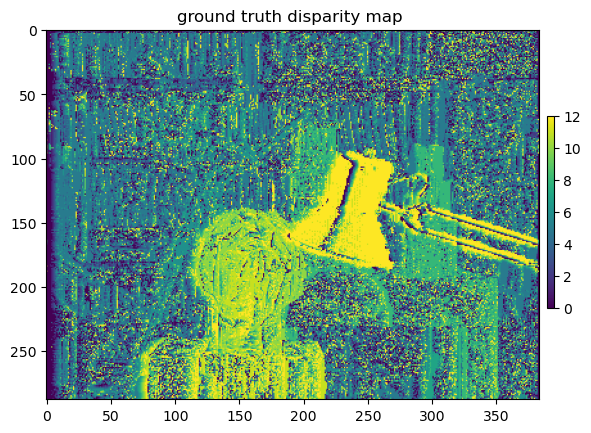

In [25]:
LinesMap = viterbi(im_left, im_right, d_min, d_max, 0)
plt.title("ground truth disparity map ")
plt.imshow(LinesMap, vmin = 0, vmax = d_max)
plt.colorbar(cax=plt.axes([0.91, 0.3, 0.01, 0.4]))

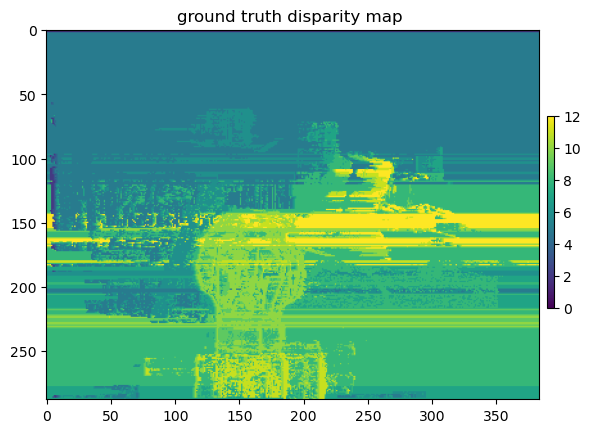

In [26]:
LinesMap = viterbi(im_left, im_right, d_min, d_max, 10000)
plt.title("ground truth disparity map ")
plt.imshow(LinesMap, vmin = 0, vmax = d_max)
plt.colorbar(cax=plt.axes([0.91, 0.3, 0.01, 0.4]))

### Problem 7(b): Test the case where the photoconsistency term $D_p(d)$ is computed by averaging SD in some small window of size $h$. That is, for each disparity $d$ you should replace 2D array $\text{SD_array}(d)$ in Problem 7(a) by $$\text{SD_array}(d)   \;\;\;\;\;\longleftarrow\;\;\;\;  windSum(SD(d),h).$$ Compare the results for different window sizes $h\in\{1,3,5\}$. Feel free to fine tune regularization parameter $w$ for each case trying to obtain the best results possible. 
### NOTE 1: $h=1$ should be equivalent to Problem 7(a) above. 
### NOTE 2: this version combines window-based stereo with regularization along scan-lines. The case when $w=0$ should give the same results as in Problem 6(c).  

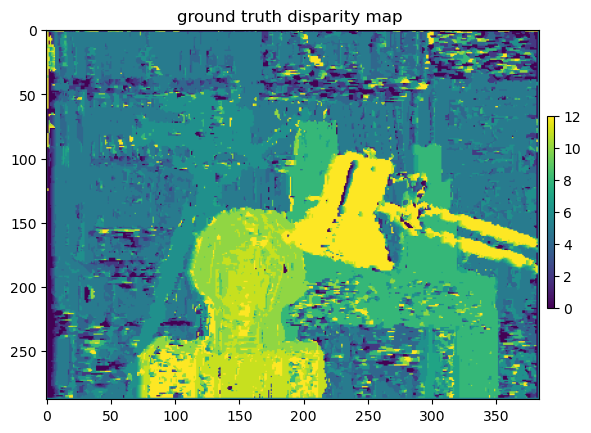

In [27]:
LinesMap = viterbi_7b(im_left, im_right, d_min, d_max, 3,3)
empty_grid = np.ogrid[0:im_left.shape[0]]


plt.title("ground truth disparity map ")
plt.imshow(LinesMap, vmin = 0, vmax = d_max)
plt.colorbar(cax=plt.axes([0.91, 0.3, 0.01, 0.4]))

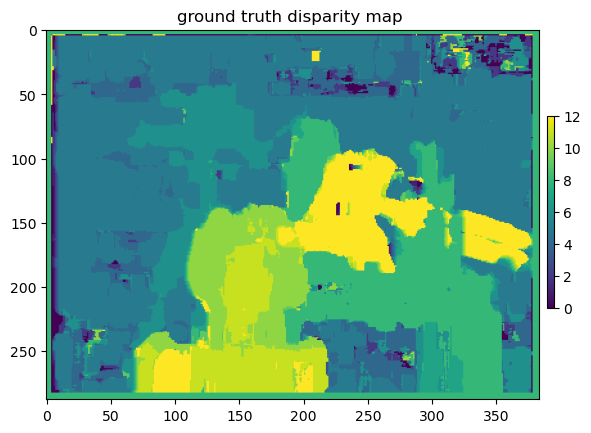

In [28]:
LinesMap = viterbi_7b(im_left, im_right, d_min, d_max, 1,10)
empty_grid = np.ogrid[0:im_left.shape[0]]


plt.title("ground truth disparity map ")
plt.imshow(LinesMap, vmin = 0, vmax = d_max)
plt.colorbar(cax=plt.axes([0.91, 0.3, 0.01, 0.4]))

### Problem 8 (aligning disparity boundaries with intensity edges): test the following case where regularization weights $w_{pq}$ depend on a specific pair of neighboring points $$V_{pq}(d_p,d_q) = w_{pq}|d_p-d_q|$$ rather than all being equal to one constant $w_{pq}=w$, as in Problem 7. For such locally adaptive regularization weights $w_{pq}$ it is common to use local intensity contrast (in the reference image)  $$w_{pq}=w\exp\frac{-\|I_p-I_q\|^2}{2\sigma^2}$$ which weighs the overall regularization constant $w$ by a Gaussian kernel (in RGB or grey-scale space). The latter makes it cheaper to draw large disparity jumps at "contrast edges" or "contrast boundaries" that are likely to happen at object boundaries. Note that bandwith parameter $\sigma$ is important - it controls sensitivity to contrast edges. Discuss the results.

In [29]:
def mat_arr_mult(m,c):
     (m.T * c).T

In [30]:
# the bandwidth param is equivalent to sigma

def wpq(drange, SD_array_image, w, p, bandwidth_param):
    empty_grid = np.ogrid[0:drange,0:drange]
    i = empty_grid[0]
    k = empty_grid[1]
    return w*np.exp(-SD_array_image[k, :, p][0]/(2 * bandwidth_param * bandwidth_param) )
     

In [31]:
def viterbi_8(im_left, im_right, d_min, d_max, w , window_size, bandwidth_param):
    drange = d_max - d_min + 1
    # the depth, the pixels and the other rows in the image
    E_bar = np.zeros((drange,im_left.shape[0],im_left.shape[1]))
    #print(E_bar.shape)
    SD_array_image = SD_array(im_left, im_right, d_min, d_max)


    for p in range(1,im_left.shape[1]):
        empty_grid = np.ogrid[0:drange,0:drange]
        i = empty_grid[0]
        k = empty_grid[1]
        #candidate_arrays = E_bar[i,p - 1] + (SD_array_image[k, row, p] + w * np.abs(k - i))
        # the new_cost_array is the array in which the potential new costs are stored
        # it is equivalent to the red lines
        # The candidate_arrays are the variouse costs assoiciated with setting the disparity value to be k 
        # where the last node have disparity value i
        # In this case I need to have the third row which is the number of line scans there are
        V_arr = np.ones(im_left.shape[0])[np.newaxis,np.newaxis, :] * V(drange)[:,:,np.newaxis]
        wpq_arr = wpq(drange, SD_array_image, w, p, bandwidth_param)
        line_scan_ind = np.arange(0, im_left.shape[0], dtype=int)        
        V_arr =np.einsum('ijk,jk->jik',V_arr, wpq_arr)
        
        candidate_arrays = E_bar[i, :, p - 1] + (SD_array_image[k, :, p] + V_arr)
    
        
        
        
        # One need to take the minimum value along axis 0 to get the minimum values of i that needs to be taken for each k
        E_bar[k, :, p] = np.min(candidate_arrays,axis = 0)    
    
    #print(E_bar)
    
    
    
    
    
    p = im_left.shape[1] - 1

    #print(E_bar[:,:,p])
    cur_val = np.min(E_bar[:,:,p], axis = 0)
    
    #print(cur_val)
    cur_k = np.argmin(E_bar[:,:,p], axis = 0)

    #print(cur_k)
    
    
    dp_backtracking = cur_k[:,np.newaxis]

    #print(dp_backtracking.shape)
    p = p - 1
    while( p >= 0 ):
        empty_grid = np.ogrid[0:drange,0:drange]
        i = empty_grid[0]
        k = empty_grid[1]
        # the new_cost_array is the array in which the potential new costs are stored
        # it is equivalent to the red lines
        # The candidate_arrays are the variouse costs assoiciated with setting the disparity value to be k 
        # where the last node have disparity value i
        # In this case I need to have the third row which is the number of line scans there are
        V_arr = np.ones(im_left.shape[0])[np.newaxis,np.newaxis, :] * V(drange)[:,:,np.newaxis]
        wpq_arr = wpq(drange, SD_array_image, w, p, bandwidth_param)
        line_scan_ind = np.arange(0, im_left.shape[0], dtype=int)        
        V_arr =np.einsum('ijk,jk->jik',V_arr, wpq_arr)
        
        candidate_arrays = E_bar[i, :, p - 1] + (SD_array_image[k, :, p] + V_arr)
        line_scan_ind = np.arange(0, im_left.shape[0], dtype=int)
        
        #print(wpq_arr.shape)
        
        # The cost new array gets the value of candidate_array[:,cur_k[i],:i]
        # need to get the index of the minimum value i
        New_Cost_array = candidate_arrays[:,cur_k[line_scan_ind],line_scan_ind]
        #print(New_Cost_array.shape)
        
        cur_val = np.min(New_Cost_array, axis = 0)
    
        new_k = np.argmin(New_Cost_array, axis = 0)
        #print(new_k.shape)
 
        dp_backtracking = np.hstack((new_k[:,np.newaxis],dp_backtracking))
        p = p - 1
    return dp_backtracking
    
    
    

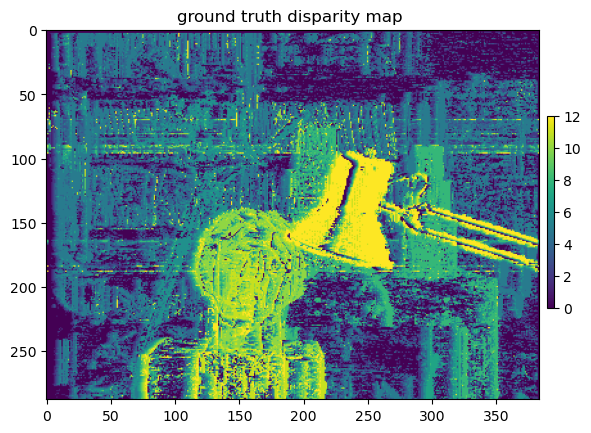

In [32]:
LinesMap = viterbi_8(im_left, im_right, d_min, d_max, 5,1,190)
empty_grid = np.ogrid[0:im_left.shape[0]]
plt.title("ground truth disparity map ")
plt.imshow(LinesMap, vmin = 0, vmax = d_max)
plt.colorbar(cax=plt.axes([0.91, 0.3, 0.01, 0.4]))

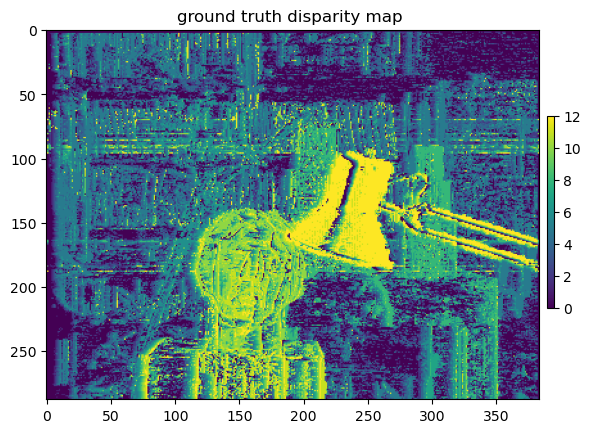

In [33]:
LinesMap = viterbi_8(im_left, im_right, d_min, d_max, 5,1,19)
empty_grid = np.ogrid[0:im_left.shape[0]]
plt.title("ground truth disparity map ")
plt.imshow(LinesMap, vmin = 0, vmax = d_max)
plt.colorbar(cax=plt.axes([0.91, 0.3, 0.01, 0.4]))

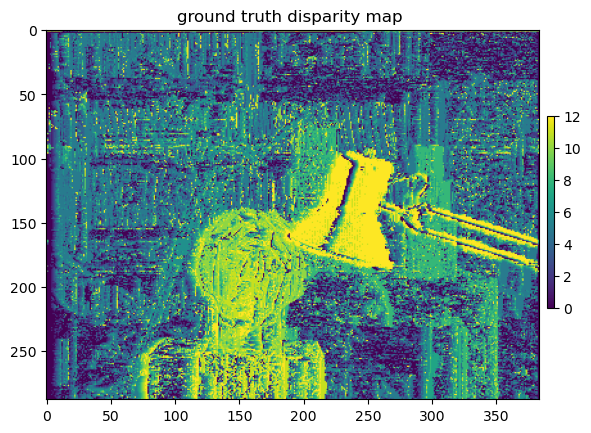

In [34]:
LinesMap = viterbi_8(im_left, im_right, d_min, d_max, 1,1,9)
empty_grid = np.ogrid[0:im_left.shape[0]]
plt.title("ground truth disparity map ")
plt.imshow(LinesMap, vmin = 0, vmax = d_max)
plt.colorbar(cax=plt.axes([0.91, 0.3, 0.01, 0.4]))

### Problem 9 [optional, small bonus]: test the performance for quadratic and (robust) truncated-quadratic regularization terms $$V_{pq}(d_p,d_q) = w_{pq}|d_p-d_q|^2\;\;\;\text{and}\;\;\;\;V_{pq}(d_p,d_q) = w_{pq}\, min\{|d_p-d_q|^2,T\}.$$ Discuss the differences in the results, if any.

In [35]:
def viterbi_9a(im_left, im_right, d_min, d_max, w , window_size):
    drange = d_max - d_min + 1
    # the depth, the pixels and the other rows in the image
    E_bar = np.zeros((drange,im_left.shape[0],im_left.shape[1]))
    #print(E_bar.shape)
    SD_array_image = SD_array(im_left, im_right, d_min, d_max)


    for p in range(1,im_left.shape[1]):
        empty_grid = np.ogrid[0:drange,0:drange]
        i = empty_grid[0]
        k = empty_grid[1]
        #candidate_arrays = E_bar[i,p - 1] + (SD_array_image[k, row, p] + w * np.abs(k - i))
        # the new_cost_array is the array in which the potential new costs are stored
        # it is equivalent to the red lines
        # The candidate_arrays are the variouse costs assoiciated with setting the disparity value to be k 
        # where the last node have disparity value i
        # In this case I need to have the third row which is the number of line scans there are
        V_arr = np.ones(im_left.shape[0])[np.newaxis,np.newaxis, :] * V(drange)[:,:,np.newaxis]
        # wpq_arr = wpq(drange, SD_array_image, w, p, bandwidth_param)
        line_scan_ind = np.arange(0, im_left.shape[0], dtype=int)        
        V_arr = V_arr * V_arr
        
        candidate_arrays = E_bar[i, :, p - 1] + (SD_array_image[k, :, p] + V_arr)
    
        
        
        
        # One need to take the minimum value along axis 0 to get the minimum values of i that needs to be taken for each k
        E_bar[k, :, p] = np.min(candidate_arrays,axis = 0)    
    
    #print(E_bar)
    
    
    
    
    
    p = im_left.shape[1] - 1

    #print(E_bar[:,:,p])
    cur_val = np.min(E_bar[:,:,p], axis = 0)
    
    #print(cur_val)
    cur_k = np.argmin(E_bar[:,:,p], axis = 0)

    #print(cur_k)
    
    
    dp_backtracking = cur_k[:,np.newaxis]

    #print(dp_backtracking.shape)
    p = p - 1
    while( p >= 0 ):
        empty_grid = np.ogrid[0:drange,0:drange]
        i = empty_grid[0]
        k = empty_grid[1]
        # the new_cost_array is the array in which the potential new costs are stored
        # it is equivalent to the red lines
        # The candidate_arrays are the variouse costs assoiciated with setting the disparity value to be k 
        # where the last node have disparity value i
        # In this case I need to have the third row which is the number of line scans there are
        V_arr = np.ones(im_left.shape[0])[np.newaxis,np.newaxis, :] * V(drange)[:,:,np.newaxis]
        # wpq_arr = wpq(drange, SD_array_image, w, p, bandwidth_param)
        line_scan_ind = np.arange(0, im_left.shape[0], dtype=int)        
        V_arr = V_arr * V_arr
        # V_arr =np.einsum('ijk,jk->jik',V_arr, wpq_arr)
        
        candidate_arrays = E_bar[i, :, p - 1] + (SD_array_image[k, :, p] + V_arr)
        line_scan_ind = np.arange(0, im_left.shape[0], dtype=int)
        
        #print(wpq_arr.shape)
        
        # The cost new array gets the value of candidate_array[:,cur_k[i],:i]
        # need to get the index of the minimum value i
        New_Cost_array = candidate_arrays[:,cur_k[line_scan_ind],line_scan_ind]
        #print(New_Cost_array.shape)
        
        cur_val = np.min(New_Cost_array, axis = 0)
    
        new_k = np.argmin(New_Cost_array, axis = 0)
        #print(new_k.shape)
 
        dp_backtracking = np.hstack((new_k[:,np.newaxis],dp_backtracking))
        p = p - 1
    return dp_backtracking
    
    
    

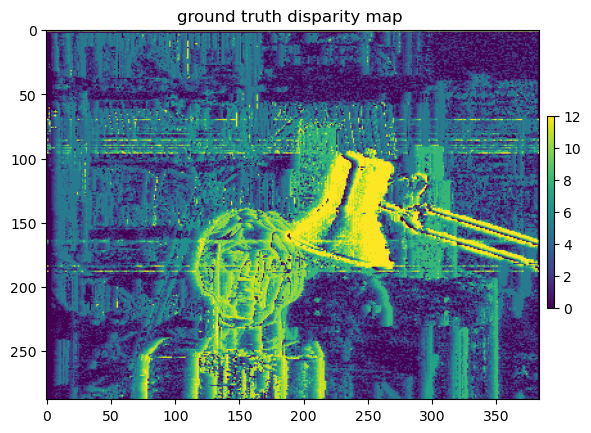

In [36]:
LinesMap = viterbi_9a(im_left, im_right, d_min, d_max, 1,1,)
empty_grid = np.ogrid[0:im_left.shape[0]]
plt.title("ground truth disparity map ")
plt.imshow(LinesMap, vmin = 0, vmax = d_max)
plt.colorbar(cax=plt.axes([0.91, 0.3, 0.01, 0.4]))

In [37]:
def viterbi_9b(im_left, im_right, d_min, d_max, w , window_size, T):
    drange = d_max - d_min + 1
    # the depth, the pixels and the other rows in the image
    E_bar = np.zeros((drange,im_left.shape[0],im_left.shape[1]))
    #print(E_bar.shape)
    SD_array_image = SD_array(im_left, im_right, d_min, d_max)


    for p in range(1,im_left.shape[1]):
        empty_grid = np.ogrid[0:drange,0:drange]
        i = empty_grid[0]
        k = empty_grid[1]
        #candidate_arrays = E_bar[i,p - 1] + (SD_array_image[k, row, p] + w * np.abs(k - i))
        # the new_cost_array is the array in which the potential new costs are stored
        # it is equivalent to the red lines
        # The candidate_arrays are the variouse costs assoiciated with setting the disparity value to be k 
        # where the last node have disparity value i
        # In this case I need to have the third row which is the number of line scans there are
        V_arr = np.ones(im_left.shape[0])[np.newaxis,np.newaxis, :] * V(drange)[:,:,np.newaxis]
        # wpq_arr = wpq(drange, SD_array_image, w, p, bandwidth_param)
        line_scan_ind = np.arange(0, im_left.shape[0], dtype=int)      
        V_arr = np.minimum(np.ones(V_arr.shape) * T, V_arr * V_arr)
        candidate_arrays = E_bar[i, :, p - 1] + (SD_array_image[k, :, p] + V_arr)
    
        
        
        
        # One need to take the minimum value along axis 0 to get the minimum values of i that needs to be taken for each k
        E_bar[k, :, p] = np.min(candidate_arrays,axis = 0)    
    
    #print(E_bar)
    
    
    
    
    
    p = im_left.shape[1] - 1

    #print(E_bar[:,:,p])
    cur_val = np.min(E_bar[:,:,p], axis = 0)
    
    #print(cur_val)
    cur_k = np.argmin(E_bar[:,:,p], axis = 0)

    #print(cur_k)
    
    
    dp_backtracking = cur_k[:,np.newaxis]

    #print(dp_backtracking.shape)
    p = p - 1
    while( p >= 0 ):
        empty_grid = np.ogrid[0:drange,0:drange]
        i = empty_grid[0]
        k = empty_grid[1]
        # the new_cost_array is the array in which the potential new costs are stored
        # it is equivalent to the red lines
        # The candidate_arrays are the variouse costs assoiciated with setting the disparity value to be k 
        # where the last node have disparity value i
        # In this case I need to have the third row which is the number of line scans there are
        V_arr = np.ones(im_left.shape[0])[np.newaxis,np.newaxis, :] * V(drange)[:,:,np.newaxis]
        # wpq_arr = wpq(drange, SD_array_image, w, p, bandwidth_param)
        line_scan_ind = np.arange(0, im_left.shape[0], dtype=int)        
        V_arr = np.minimum(np.ones(V_arr.shape) * T, V_arr * V_arr)
        # V_arr =np.einsum('ijk,jk->jik',V_arr, wpq_arr)
        
        candidate_arrays = E_bar[i, :, p - 1] + (SD_array_image[k, :, p] + V_arr)
        line_scan_ind = np.arange(0, im_left.shape[0], dtype=int)
        
        #print(wpq_arr.shape)
        
        # The cost new array gets the value of candidate_array[:,cur_k[i],:i]
        # need to get the index of the minimum value i
        New_Cost_array = candidate_arrays[:,cur_k[line_scan_ind],line_scan_ind]
        #print(New_Cost_array.shape)
        
        cur_val = np.min(New_Cost_array, axis = 0)
    
        new_k = np.argmin(New_Cost_array, axis = 0)
        #print(new_k.shape)
 
        dp_backtracking = np.hstack((new_k[:,np.newaxis],dp_backtracking))
        p = p - 1
    return dp_backtracking
    
    
    

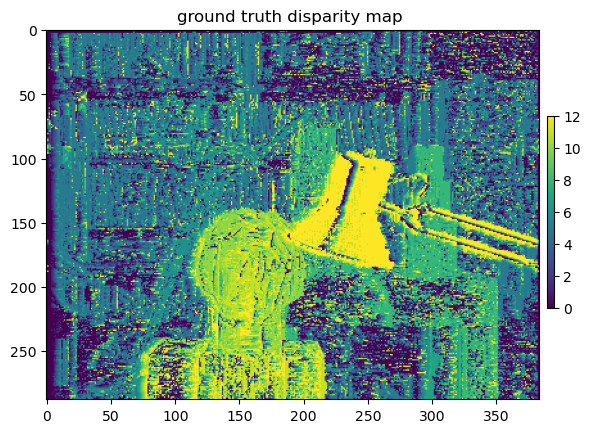

In [38]:
LinesMap = viterbi_9b(im_left, im_right, d_min, d_max, 1,1,5)
empty_grid = np.ogrid[0:im_left.shape[0]]
plt.title("ground truth disparity map ")
plt.imshow(LinesMap, vmin = 0, vmax = d_max)
plt.colorbar(cax=plt.axes([0.91, 0.3, 0.01, 0.4]))

Since the first option highly peanalizes the disparity change the disparity differences between the pixels within a scanline are small. However the existance of streaklines are very noticable. Whereas the second image have lower differences peanilized on a quadratic scale and higher differences as a constant T. Thus it is giving a level of tolorance to higher levels of disparity differences. 